In [1]:
!pip -q install torchxrayvision
!pip -q install image_tabular

In [2]:
# torch.__version__

In [3]:
import matplotlib.pyplot as plt
import os
import shutil
import torch
import torchxrayvision as xrv
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import fastai
from fastai.tabular.data import TabularList
import image_tabular as imtab
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import math


from fastai.vision import *
from fastai.tabular import *
from image_tabular.core import *
from image_tabular.dataset import *
from image_tabular.model import *
from image_tabular.metric import *

In [4]:
!rm -rf covid-chestxray-dataset

In [5]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset
d = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 23.45 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Checking out files: 100% (1174/1174), done.


# **Configurations**

In [6]:
# data split
test_pct=0.2
valid_pct=0.2

# models param
##TAB
tab_out_sz = 18 # output size that will be concatenated with the CNN, same output size
dropout_prob_tab = 0.2
tab_layers = [100, 200] # the sizes of the hidden fully connected layers between the input (after embedding) and before the classification layer. The number of hidden layers is determined by the length of the list.
# FUTURE WORK: tune this, for our data size, [100,200] seems highly overfitted. according to the rule of thumb bellow, we should have 0
# https://forums.fast.ai/t/an-attempt-to-find-the-right-hidden-layer-size-for-your-tabular-learner/45714
# len_train = 110; alpha = 2; n_input=8; n_output=18; io=n_input+n_output; numHiddenLayers=2
# tab_layers = [(len_train//(alpha*(io)))//numHiddenLayers]*numHiddenLayers

##CNN
cnn_out_sz = 18 # following xrv.models.DenseNet output layer
image_size = 224 # to fit xrv.models.DenseNet
image_convert_mode = 'RGB'

##CNN_TAB
cnn_tabular_dropout_prob = 0.2
cnn_tabular_layers = [cnn_out_sz + tab_out_sz, 32]
cnn_tabular_out_sz = 6 #number of classes
batch_size = 64
n_epoch = 10
lr = 1.32e-02


# misc
seed=42
data_path = Path("./covid-chestxray-dataset/")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **Creating label**

In [7]:
def generate_label(x):
    # no data
    if np.all(pd.isna([x.survival, x.intubated, x.went_icu, x.needed_supplemental_O2])):
        return np.NaN

    # didn't survive
    if x.survival=='N':
        return '5'

    #either survived or survival is unknown
    if x.intubated == 'Y':
        return '4'
    if x.went_icu == 'Y' and x.needed_supplemental_O2 == 'Y':
        return '3'
    if x.went_icu == 'Y':
        return '2'
    if x.needed_supplemental_O2 == 'Y':
        return '1'
    return '0'

In [8]:
metadata = d.csv
metadata['severity_class']=metadata.apply(generate_label, axis=1)

# **Tabular Data handling**

## **Avoiding confounders**

In [9]:
filtered_metadata = metadata.loc[(metadata.view!="APS") & (metadata.offset>=0) & (metadata.offset<=8) & (metadata.intubation_present != 'Y') & (metadata.in_icu != 'Y')]
filtered_metadata = filtered_metadata[['index','patientid','sex','age','RT_PCR_positive','temperature','pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'severity_class' ,'filename']]

## **Handling missing data**

In [10]:
filtered_metadata = filtered_metadata.dropna(subset=['severity_class'], how='any')

In [11]:
filtered_metadata.head()

,index,patientid,sex,age,RT_PCR_positive,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,severity_class,filename
0,0,2,M,65.0,Y,NaN,NaN,NaN,NaN,NaN,1,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,1,2,M,65.0,Y,NaN,NaN,NaN,NaN,NaN,1,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,2,2,M,65.0,Y,NaN,NaN,NaN,NaN,NaN,1,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,3,2,M,65.0,Y,NaN,NaN,NaN,NaN,NaN,1,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,4,4,F,52.0,Y,NaN,NaN,NaN,NaN,NaN,0,nejmc2001573_f1a.jpeg


## **Train test and validation split**

In [12]:
train_df, test_df = train_test_split(filtered_metadata, test_size=test_pct)

# idx for validation, shared by image and tabular data
val_idx = get_valid_index(train_df, valid_pct=valid_pct, seed=seed)

## **Preparing fastai LabelLists**

### **Features**

In [13]:
# Features with categorical values
cat_names = ['sex', 'RT_PCR_positive']

# Features with continious values
cont_names = ['age', 'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count']

### **Labels**

In [14]:
# Target
dep_var = ['severity_class']

### **Ensambling the tabular dataset**

In [15]:
procs = [FillMissing, Categorify, Normalize] 
# FillMissing fills the missing values in continuous columns. Catagorical 
# variables are left untouched (their missing value will be replaced by code 0 
# in the TabularDataBunch). The fill stratagy is MEDIAN; nans are replaced by 
# the median value of the column

tab_data = (TabularList.from_df(train_df, path=data_path, cat_names=cat_names, cont_names=cont_names, procs=procs)
            .split_by_idx(val_idx)
            .label_from_df(cols=dep_var))

test_tab_data = TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names, processor=tab_data.train.x.processor)
tab_data = tab_data.add_test(test_tab_data)

In [16]:
# Iterating over tab_data items, printing class name and items len, using 
# `show_some()` to return the representation of the first 5 elements in `items`.
tab_data
# Note that the Test LabelList has no labels. Like in Kaggle competitions.

LabelLists;

Train: LabelList (88 items)
x: TabularList
sex F; RT_PCR_positive #na#; age_na False; temperature_na True; pO2_saturation_na True; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age -2.0967; temperature 0.0644; pO2_saturation 0.2683; leukocyte_count -0.0339; neutrophil_count -0.1248; lymphocyte_count -0.1171; ,sex M; RT_PCR_positive Y; age_na False; temperature_na False; pO2_saturation_na False; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age -1.2513; temperature -2.7682; pO2_saturation 1.0259; leukocyte_count -0.0339; neutrophil_count -0.1248; lymphocyte_count -0.1171; ,sex M; RT_PCR_positive Y; age_na False; temperature_na True; pO2_saturation_na True; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age 0.8622; temperature 0.0644; pO2_saturation 0.2683; leukocyte_count -0.0339; neutrophil_count -0.1248; lymphocyte_count -0.1171; ,sex M; RT_PCR_positive Y; age_na False; temperature

### one example from the tabular data

In [17]:
print(f"features: {tab_data.train[8][0]}")
print(f"class: {tab_data.train[8][1]}")

features: sex F; RT_PCR_positive Y; age_na False; temperature_na False; pO2_saturation_na True; leukocyte_count_na True; neutrophil_count_na True; lymphocyte_count_na True; age 0.2282; temperature -3.9484; pO2_saturation 0.2683; leukocyte_count -0.0339; neutrophil_count -0.1248; lymphocyte_count -0.1171; 
class: 0


# **Image Data handling**

## **Creating test and train image folders**

In [18]:
def create_sub_image_folder(dataframe, imgs_type, sub_dir_by_lable : bool):
  filtered_imgpath = d.imgpath + '/' + imgs_type + '/'
  filtered_filenames = dataframe.filename + ';' + dataframe.severity_class
  if not os.path.exists(filtered_imgpath):
      os.mkdir(filtered_imgpath)
  if sub_dir_by_lable:
    for severity_class in list(dataframe.severity_class):
        if not os.path.exists(filtered_imgpath + f'/{severity_class}'):
            os.mkdir(filtered_imgpath + f'/{severity_class}')
  for file_name_label in filtered_filenames:
      file_name, label = file_name_label.split(';')
      src = d.imgpath + file_name
      dst = filtered_imgpath + label + '/' + file_name if sub_dir_by_lable else filtered_imgpath + file_name
      if not os.path.exists(dst):
          shutil.copyfile(src, dst)

In [19]:
create_sub_image_folder(train_df, 'train', False)
create_sub_image_folder(test_df, 'test', False)
filtered_img_base_path = d.imgpath + '/'

## **Preparing fastai LabelLists**

In [20]:
tfms = fastai.vision.transform.get_transforms(do_flip=False, 
                                                flip_vert=False, max_rotate=10,
                                                max_zoom=1.1, max_lighting=0.2, 
                                                p_affine=0.85, p_lighting=0.4, 
                                                max_warp=0.2, xtra_tfms=None)

image_data = (ImageList.from_df(train_df, path=d.imgpath, cols="filename", 
                                folder="train", convert_mode = image_convert_mode)
                        .split_by_idx(val_idx)
                        .label_from_df(cols=dep_var)
                        ).transform(tfms).transform([crop_pad(), crop_pad()], size=image_size)
            
test_image_data = ImageList.from_df(test_df, path=d.imgpath, cols="filename",
                                    folder="test", convert_mode = image_convert_mode)
image_data = image_data.add_test(test_image_data)
image_data

LabelLists;

Train: LabelList (88 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,1,0,0
Path: covid-chestxray-dataset/images;

Valid: LabelList (20 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
4,0,4,0,0
Path: covid-chestxray-dataset/images;

Test: LabelList (28 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: covid-chestxray-dataset/images

### one example from the image data

Class: 0


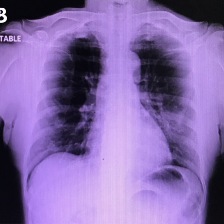

In [21]:
print(f"Class: {image_data.train[8][1]}")
image_data.train[8][0]

# **Integrate image and tabular data**

In [22]:
integrate_train, integrate_val, integrate_test = get_imagetabdatasets(image_data, tab_data)

db = DataBunch.create(integrate_train, integrate_val, integrate_test, path=data_path, bs=batch_size)
db

DataBunch;

Train: <image_tabular.dataset.ImageTabDataset object at 0x7ff87ae3b3d0>;

Valid: <image_tabular.dataset.ImageTabDataset object at 0x7ff87ae3b410>;

Test: <image_tabular.dataset.ImageTabDataset object at 0x7ff87ae3b450>

In [23]:
x, y = next(iter(db.train_dl))

print(f"x holds {len(x)} items")
print(f"first item - batch of images ({x[0].shape})")
print(f"second item - holds both categorial ({x[1][0].shape}) and continuous ({x[1][1].shape}) tabular data")

print(f"y is the targets ({y.shape})")

x holds 2 items
first item - batch of images (torch.Size([64, 3, 224, 224]))
second item - holds both categorial (torch.Size([64, 8])) and continuous (torch.Size([64, 6])) tabular data
y is the targets (torch.Size([64]))


In [24]:
x, y = next(iter(db.train_dl))
y

tensor([0, 3, 1, 0, 0, 2, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 2,
        0, 1, 3, 0, 0, 0, 0, 2, 3, 4, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
        0, 1, 3, 1, 0, 3, 3, 2, 0, 2, 0, 0, 2, 0, 3, 1])

# **The models**

### **The tabular model**

In [25]:
# embedding sizes of categorical data. Return the default embedding sizes suitable for this data. Using the rule of thumb - min(600, round(1.6 * n_cat**0.56))
# Future work: think if we want to replace that with one-hot, since they are binary
emb_szs = tab_data.train.get_emb_szs()
print(f"emb_szs: {emb_szs}")

# The tabular model
tabular_model = TabularModel(emb_szs=emb_szs, n_cont = len(cont_names), out_sz=tab_out_sz, layers=tab_layers, ps=dropout_prob_tab)
tabular_model

emb_szs: [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]


TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=100, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=200, out_features=18, bias=True)
  )
)

## **The CNN model** 
Using pretrained xrv.models.DenseNet for transfer learning

In [26]:
# cnn_model = xrv.models.DenseNet(weights="densenet121-res224-all") <- trained on xrays, but doesn't reproduce
cnn_model = models.densenet121(pretrained=True)
cnn_model.classifier

cnn_model.classifier = torch.nn.Linear(1024, 18)

In [27]:
# Don't backprop model parameters!
for param in cnn_model.parameters():
    param.requires_grad = False

In [28]:
# FUTURE WORK: modify CNN architecture

# # New classifier suggestion
# cnn_model.classifier = nn.Sequential(nn.Linear(1024, 512),
#                           nn.ReLU(),
#                           nn.Dropout(0.2),
#                           nn.Linear(512,256),
#                           nn.ReLU(),
#                           nn.Dropout(0.2),
#                           nn.Linear(256,18))

## **The integrated CNN Tabular model** 

In [29]:
img_tabular_model = CNNTabularModel(cnn_model,
                                  tabular_model,
                                  layers = cnn_tabular_layers,
                                  ps=cnn_tabular_dropout_prob,
                                  out_sz=cnn_tabular_out_sz).to(device)

In [30]:
img_tabular_model

CNNTabularModel(
  (cnn_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mo

In [31]:
# check model output dimension, should be (batch_size, 6)
img_tabular_model(*x).shape

torch.Size([64, 6])

In [32]:
print("Class distribution of train set - unbalanced:")
print(train_df.severity_class.value_counts().sort_index())

weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(train_df.severity_class),
                                                  train_df.severity_class)

print(f"\nThe weights (calculated with respect to label distribution of train set): {np.round(weights,2)}")

Class distribution of train set - unbalanced:
0    62
1     9
2    11
3     2
4    18
5     8
Name: severity_class, dtype: int64

The weights (calculated with respect to label distribution of train set): [0.3  2.04 1.67 9.17 1.02 2.29]


In [33]:
# adjust loss function weight because the dataset is unbalanced
loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [34]:
# Future work: tune optimizer better
learn = Learner(db, img_tabular_model, metrics=[accuracy, Recall(), Precision(), error_rate], loss_func=loss_func)

In [35]:
learn.model

CNNTabularModel(
  (cnn_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mo

In [36]:
# Run the following to see how we found the best learning rate
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

# **Training**

In [37]:
# train
learn.fit(epochs=n_epoch, lr=lr)

epoch,train_loss,valid_loss,accuracy,recall,precision,error_rate,time
0,1.986344,1.599622,0.300000,nan,nan,0.700000,00:35
1,1.679011,1.539759,0.300000,nan,nan,0.700000,00:35
2,1.478894,1.457856,0.350000,nan,nan,0.650000,00:36
3,1.347351,1.373854,0.300000,nan,nan,0.700000,00:35
4,1.250767,1.303051,0.300000,nan,nan,0.700000,00:37
5,1.162721,1.243649,0.300000,nan,nan,0.700000,00:38
6,1.111043,1.199036,0.300000,nan,nan,0.700000,00:35
7,1.054883,1.170239,0.300000,nan,nan,0.700000,00:36
8,0.992716,1.165550,0.300000,nan,nan,0.700000,00:39
9,0.943545,1.183587,0.300000,nan,nan,0.700000,00:37


# **Prediction on the test set**

In [38]:
# make predictions for the test set
preds, y = learn.get_preds(DatasetType.Test)

In [39]:
test_labels = list(map(int, test_df['severity_class'].values))
y = torch.tensor(test_labels)

In [40]:
preds

tensor([[0.0014, 0.0084, 0.0044, 0.9787, 0.0023, 0.0049],
        [0.3131, 0.0680, 0.1952, 0.0382, 0.1720, 0.2134],
        [0.0606, 0.1238, 0.2090, 0.4189, 0.0916, 0.0960],
        [0.1770, 0.1307, 0.1666, 0.2363, 0.1734, 0.1159],
        [0.1580, 0.1715, 0.1531, 0.2893, 0.1086, 0.1195],
        [0.3254, 0.0910, 0.1286, 0.0704, 0.1966, 0.1879],
        [0.2634, 0.0808, 0.2449, 0.1275, 0.1491, 0.1343],
        [0.1958, 0.0941, 0.1601, 0.3135, 0.1217, 0.1149],
        [0.2343, 0.0880, 0.1798, 0.1931, 0.1663, 0.1384],
        [0.1462, 0.1033, 0.1696, 0.3466, 0.1168, 0.1174],
        [0.3672, 0.1717, 0.1037, 0.0636, 0.1672, 0.1267],
        [0.1292, 0.1394, 0.1807, 0.3257, 0.0986, 0.1264],
        [0.0698, 0.1945, 0.1686, 0.3866, 0.0780, 0.1026],
        [0.2244, 0.1303, 0.1536, 0.1644, 0.1688, 0.1585],
        [0.2213, 0.0936, 0.1524, 0.2312, 0.1521, 0.1494],
        [0.0446, 0.0630, 0.1098, 0.6574, 0.0605, 0.0647],
        [0.0273, 0.0772, 0.1145, 0.6933, 0.0383, 0.0494],
        [0.233

In [41]:
y

tensor([0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 5, 5, 0, 0, 4, 5, 2, 0, 0,
        4, 2, 4, 0])

## Check precision and recall

In [42]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc
_, preds_labels = torch.max(preds ,dim=1) # Set the severity with the highest probability as label
print(f"precision score: {precision_score(y, preds_labels, average='weighted')}")
print(f"recall score: {recall_score(y, preds_labels, average='weighted')}")

precision score: 0.6445578231292517
recall score: 0.2857142857142857


## Check the ROC for our production use case - over / under a severity threshold

setting the threshold at 3 (over 3 - the system alerts, 3 and above - the system does not)

In [43]:
y_binary = np.where(np.array(y) >= 3, 1, 0)
preds_labels_binary = np.where(np.array(preds_labels) >= 3, 1, 0)
fpr, tpr, threshold = roc_curve(y_binary, preds_labels_binary)
roc_auc = auc(fpr, tpr)

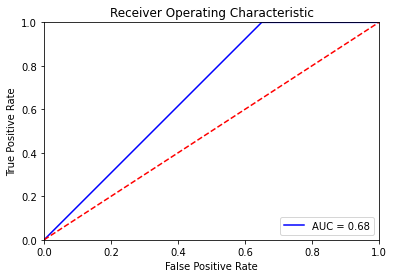

In [44]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Explainability**

In [45]:
# Preprocess the image
def preprocess(image, size=224):
    transform = transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Lambda(lambda x: x[None]),
        # transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
    ])
    return transform(image)

'''
    Y = (X - μ)/(σ) => Y ~ Distribution(0,1) if X ~ Distribution(μ,σ)
    => Y/(1/σ) follows Distribution(0,σ)
    => (Y/(1/σ) - (-μ))/1 is actually X and hence follows Distribution(μ,σ)
'''

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))


def create_saliency_map(image_filename='000001-17.jpg'):
    img = PIL.Image.open(f'/content/covid-chestxray-dataset/images/{image_filename}', ).convert(image_convert_mode)
    # preprocess the image
    X = preprocess(img)
    

    # we would run the model in evaluation mode
    cnn_model.eval()

    # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
    X.requires_grad_()

    '''
    forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
    and we also don't need softmax, we need scores, so that's perfect for us.
    '''
    scores = cnn_model(X)
    

    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]

    '''
    backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
    score_max with respect to nodes in the computation graph
    '''
    score_max.backward()

    '''
    Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
    R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
    across all colour channels.
    '''
    saliency, _ = torch.max(X.grad.data.abs(),dim=1)

    # # code to plot the saliency map as a heatmap
    # plt.imshow(saliency[0], cmap=plt.cm.hot)
    # plt.axis('off')
    # plt.show()


    transform_image_for_print = transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1)
    ])
    img_for_visual = transform_image_for_print(X)


    # Visualize the image and the saliency map
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(np.squeeze(img_for_visual.cpu().detach().numpy()), cmap="gray")
    ax[0].axis('off')
    ax[1].imshow(saliency[0].cpu(), cmap='hot')
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(img_for_visual.cpu().detach().numpy()), cmap="gray")
    ax[2].imshow(saliency[0].cpu(), cmap='hot', alpha=0.5)
    ax[2].axis('off')
    plt.tight_layout()
    fig.suptitle('The Image and Its Saliency Map')
    plt.show()



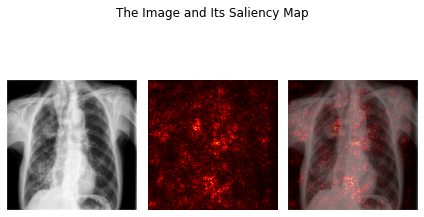

In [46]:
create_saliency_map()